In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
%load_ext autoreload
%autoreload 2

In [2]:
DEVICE = 'cuda:0'

In [3]:
# A toy model with a diffuse and point source component

def model(z, sigma = .1):
    X, Y = np.mgrid[-5:5:50j, -5:5:50j]
    
    # parameters z[0] ... z[2] determine diffuse bkg
    iso = z[0] * np.ones_like(X)
    scale = z[2] + 0.1
    disk = 10 * z[1] * np.exp(-X**2/scale**2/2)
    diff = disk + iso
    
    # N point sources
    N = int(z[4] * 10000)
    # spatial distribution uniform
    i, j = np.random.choice(50, (2, N))  # just indices
    # log normal distribution for fluxes, depends on z[3]
    f = 10**(np.random.randn(N)*0.5) * z[3]
    
    # point source map
    psc = np.zeros_like(X)
    psc[i, j] += f
    
    # Gamma-ray sky
    sky = psc + diff
    
    return np.array(sky)

In [4]:
def noisemodel(x, z, sigma = 0.1):
    x = x.copy()
    x[1] = x[1] + np.random.randn(*x[1].shape)*sigma
    return x

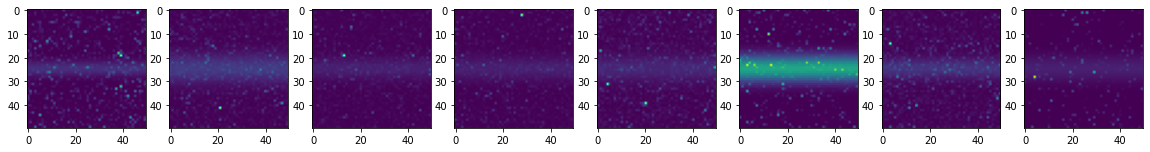

In [5]:
# Random image realizations, without noise

plt.figure(figsize=(20, 5))
for i in range(8):
    plt.subplot(1, 8, i+1)
    z = np.random.rand(5)
    x = model(z)
    plt.imshow(x)

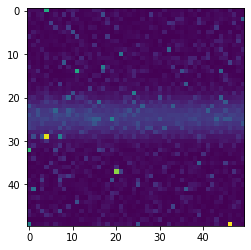

In [6]:
z0 = np.array([0.5, 0.5, 0.5, 0.5, 0.5])
zdim = len(z0)
comb1d = [[i] for i in range(zdim)]
x0 = noisemodel(model(z0), z0)
plt.imshow(x0)

In [7]:
# Convolutional network as HEAD of inference network

class Head(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0a = torch.nn.Conv2d(1, 100, 1)
        self.conv0b = torch.nn.Conv2d(100, 1, 1)
        self.conv1 = torch.nn.Conv2d(1, 10, 5)
        self.conv2 = torch.nn.Conv2d(10, 20, 5)
        self.conv3 = torch.nn.Conv2d(20, 40, 5)
        self.pool = torch.nn.MaxPool2d(2)
        
    def forward(self, x):
        nbatch = len(x)
        
        x = x.unsqueeze(1)
        x = self.conv0a(x)
        x = torch.relu(x)
        x = self.conv0b(x)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = x.view(nbatch, -1)

        return x

In [8]:
# Instantiate network

ds = swyft.DataStore().init(zdim = 5, xdim = (50, 50))

Creating empty datastore: None
...don't forget to run `init` to set up storage parameters.
Datastore initialized.


In [9]:
NROUNDS = 3
MAX_EPOCHS = 20
NSAMPLES = 10000

In [10]:
re_prev = None
for i in range(NROUNDS):
    td = swyft.TrainData(x0 = x0, zdim = zdim, noisehook = noisemodel, datastore = ds, nsamples = NSAMPLES, threshold = 1e-5, parent = re_prev)
    ds.simulate(model)
    re = swyft.RatioEstimation(zdim, td, device = DEVICE, combinations = comb1d, head = Head)
    re.train(max_epochs = MAX_EPOCHS, nbatch = 32, lr_schedule = [1e-3, 5e-4])
    re_prev = re

Constrained posterior area: 1.0
Adding 9848 new samples. Run simulator!


Simulate: 100%|██████████| 9848/9848 [00:22<00:00, 436.07it/s]


Number of output features: 160
Start training
LR iteration 0
Validation loss: 140.87855195999146
Validation loss: 132.7577543258667
Validation loss: 122.39764308929443
Validation loss: 124.23101234436035
Total epochs: 4
LR iteration 1
Validation loss: 117.26720714569092
Validation loss: 120.00588321685791
Total epochs: 2
Constrained posterior area: 0.0420686
Adding 9556 new samples. Run simulator!


Simulate: 100%|██████████| 9556/9556 [00:22<00:00, 432.83it/s]


Number of output features: 160
Start training
LR iteration 0
Validation loss: 147.72850704193115
Validation loss: 135.54937028884888
Validation loss: 132.38982486724854
Validation loss: 127.30119752883911
Validation loss: 139.10306644439697
Total epochs: 5
LR iteration 1
Validation loss: 119.93773126602173
Validation loss: 126.21604585647583
Total epochs: 2
Constrained posterior area: 0.001960672
Adding 9253 new samples. Run simulator!


Simulate: 100%|██████████| 9253/9253 [00:21<00:00, 425.69it/s]


Number of output features: 160
Start training
LR iteration 0
Validation loss: 161.28376007080078
Validation loss: 156.34913063049316
Validation loss: 150.15860652923584
Validation loss: 148.35224723815918
Validation loss: 152.35168552398682
Total epochs: 5
LR iteration 1
Validation loss: 139.61071825027466
Validation loss: 138.9425826072693
Validation loss: 145.99581956863403
Total epochs: 3


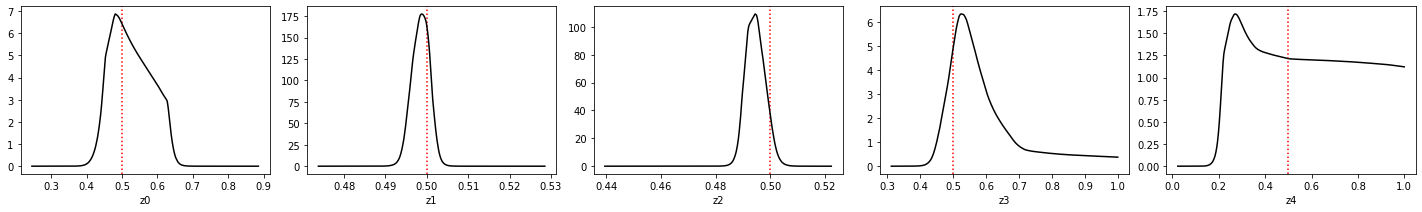

In [11]:
swyft.plot1d(re, x0 = x0, z0 = z0, cmap = 'Greys', dims = (25, 3), ncol = 5)

In [12]:
re2 = swyft.RatioEstimation(zdim, td, device = DEVICE, combinations = swyft.comb2d([0, 1, 2, 3, 4]), head = Head)
re2.train(max_epochs = MAX_EPOCHS, nbatch = 32, early_stopping_patience = 3, lr_schedule = [1e-3, 5e-4])

Number of output features: 160
Start training
LR iteration 0
Validation loss: 199.07111167907715
Validation loss: 169.05845832824707
Validation loss: 158.90059185028076
Validation loss: 168.52545070648193
Validation loss: 139.20128107070923
Validation loss: 164.28408336639404
Validation loss: 145.1410059928894
Validation loss: 148.23182249069214
Total epochs: 8
LR iteration 1
Validation loss: 137.74749851226807
Validation loss: 130.37723112106323
Validation loss: 131.04954528808594
Validation loss: 132.8822922706604
Validation loss: 150.36202001571655
Total epochs: 5


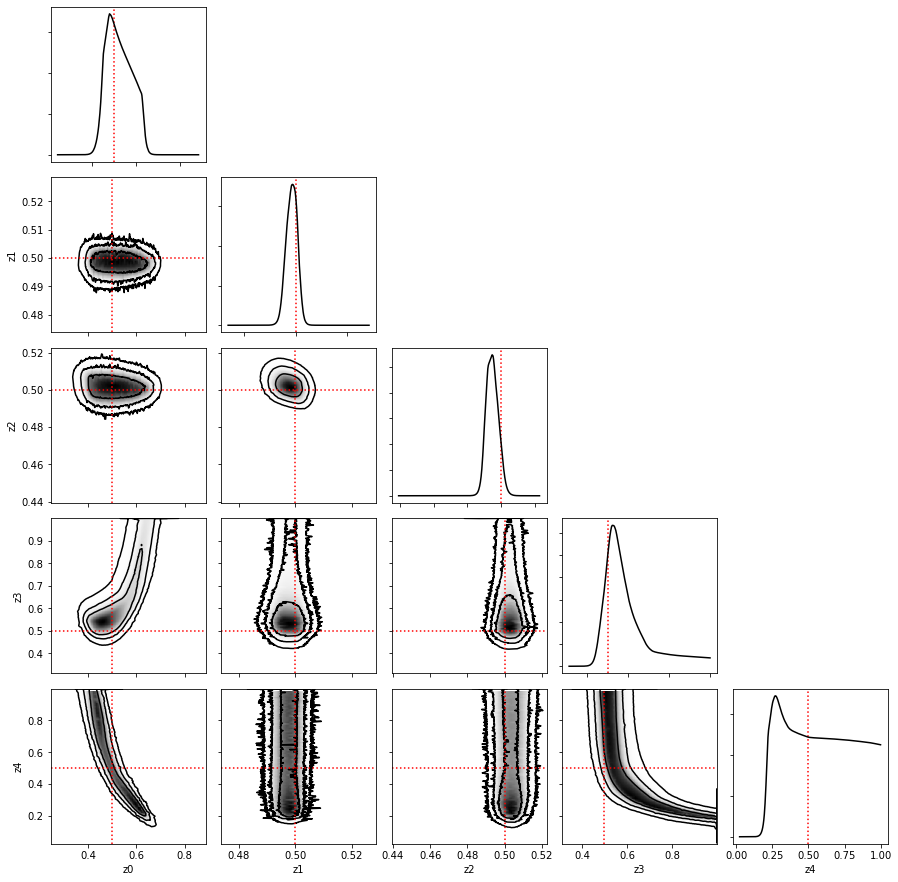

In [13]:
swyft.corner(re, re2, x0 = x0, z0 = z0, cmap = 'Greys', dim = 15, Nmax = 10000)